<a href="https://colab.research.google.com/github/o-fugi/systematicity-semantic-change/blob/main/analysis/Direction_Prediction_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this cell and then restart the runtime if you want to generate graphs

!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 4.8 MB/s 
     |████████████████████████████████| 965 kB 51.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from functools import reduce
import random as r
import matplotlib.pyplot as plt

In [ ]:
# import factor  datasets

val_df = pd.read_csv('../data/datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None)
val_df = val_df.rename(columns={0:'Word', 1:'val', 2:'aro', 3:'dom'})[['Word', 'val', 'aro', 'dom']]

conc_df = pd.read_csv('../data/datasets/brysbaert_concreteness.csv')
conc_df = conc_df.rename(columns={'Conc.M': 'conc'})[['Word', 'conc']]

freq_df = pd.read_csv('../data/datasets/COCA_freqs.csv', encoding='ISO-8859-1') # w1, coca_spok
freq_df = freq_df.rename(columns={'w1':'Word', 'coca_spok':'freq'})[['Word', 'freq']]
freq_df['freq_rank'] = freq_df['freq'].rank(ascending=False)

In [ ]:
# import semantic shift dataset

sem_shift_df = pd.read_csv('../data/datasets/cleaned_dat_sem_shift.csv')
sem_shift_df['meaning1'] = sem_shift_df['meaning1_clean']
sem_shift_df['meaning2'] = sem_shift_df['meaning2_clean']
sem_shift_df = sem_shift_df[['meaning1', 'meaning2', 'realizations']]

In [ ]:
# define how we map a sense to concreteness, valence, frequency values

skip_words = {'the', 'and', 'of', 'a', 'in', 'to', 'it', 'is', 'that', 'for', 'with', 'on', 'at', 'this', 'that', 'by', 'or', 'an', 'as', 'if', 'so', 'in'}

# take all words in the sense and and average/add values
# if conservative, only matches to full phrases separated by "or"
def senseToValue(s, df, col, average=True, conservative=False):
  s = s.lower()
  if conservative: 
    phrases = re.split(' or ', s)
  else:
    for i in "(),/":
      s = s.replace(i, "")
    phrases = re.split(' ', s)
  total_val = 0
  val_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      val = df[df['Word']==p][col].values[0]
      if not np.isnan(val):
        total_val += val
        val_data += 1
    except:
      pass
  if val_data == 0:
    total_val = np.nan
  else:
    if average:
      total_val /= val_data
  return total_val

In [ ]:
# get priors for semshift data

# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
freq_dic = {} 
val_dic = {}
val_rate_dic = {}

conservative=True

for i in range(len(sem_shift_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = sem_shift_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in conc_dic:
    x_conc = senseToValue(x, conc_df, 'conc', conservative=conservative)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc

  if y not in conc_dic:
    y_conc = senseToValue(y, conc_df, 'conc', conservative=conservative)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc

  if x not in freq_dic:
    x_freq = senseToValue(x, freq_df, 'freq', average=True, conservative=conservative)
    if not np.isnan(x_freq):
      freq_dic[x] = x_freq

  if y not in freq_dic:
    y_freq = senseToValue(y, freq_df, 'freq', average=True, conservative=conservative)
    if not np.isnan(y_freq):
      freq_dic[y] = y_freq

  if x not in val_dic:
    x_val = senseToValue(x, val_df, 'val', conservative=conservative)
    if not np.isnan(x_val):
      val_dic[x] = x_val

  if y not in val_dic:
    y_val = senseToValue(y, val_df, 'val', conservative=conservative)
    if not np.isnan(y_val):
      val_dic[y] = y_val

In [ ]:
# test prior accuracy on shifts that have values for ALL THREE variables

# create dataframes for each variable
conc_sense_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
freq_sense_df = pd.DataFrame.from_dict(freq_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'freq'})
val_sense_df = pd.DataFrame.from_dict(val_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'val'})
val_sense_df['val_rate'] = abs(val_sense_df['val'] - 0.5)

# merge into a list of all shifts
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, conc_sense_df]).drop('Word', axis=1)
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_val_df, conc_sense_df]).drop('Word', axis=1)
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_val_df, freq_sense_df]).drop('Word', axis=1)
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_val_df, freq_sense_df]).drop('Word', axis=1)
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_val_df, val_sense_df]).drop('Word', axis=1)
shift_val_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_val_df, val_sense_df]).drop('Word', axis=1)

# remove all shifts that don't have concreteness, valence, and frequency values for source and target
shift_val_df = shift_val_df.dropna()

# determine the accuracy of each variable for predicting each shift
shift_val_df['conc_ratio'] = shift_val_df['conc_x'] / shift_val_df['conc_y']
shift_val_df['freq_ratio'] = shift_val_df['freq_x'] / shift_val_df['freq_y']
shift_val_df['val_rate_ratio'] = shift_val_df['val_rate_x'] / shift_val_df['val_rate_y']

shift_val_df['conc_acc'] = np.where(shift_val_df['conc_ratio'] > 1, 1, 0)
shift_val_df['freq_acc'] = np.where(shift_val_df['freq_ratio'] > 1, 1, 0)
shift_val_df['val_rate_acc'] = np.where(shift_val_df['val_rate_ratio'] < 1, 1, 0)

# record the accuracies in lists for plotting
conc_accuracy = []
conc_accuracy.append(shift_val_df['conc_acc'].value_counts()[1] / len(shift_val_df))
conc_accuracy.append(shift_val_df[shift_val_df['realizations']>1]['conc_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>1]))
conc_accuracy.append(shift_val_df[shift_val_df['realizations']>5]['conc_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>5]))

freq_accuracy = []
freq_accuracy.append(shift_val_df['freq_acc'].value_counts()[1] / len(shift_val_df))
freq_accuracy.append(shift_val_df[shift_val_df['realizations']>1]['freq_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>1]))
freq_accuracy.append(shift_val_df[shift_val_df['realizations']>5]['freq_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>5]))

val_rate_accuracy = []
val_rate_accuracy.append(shift_val_df['val_rate_acc'].value_counts()[1] / len(shift_val_df))
val_rate_accuracy.append(shift_val_df[shift_val_df['realizations']>1]['val_rate_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>1]))
val_rate_accuracy.append(shift_val_df[shift_val_df['realizations']>5]['val_rate_acc'].value_counts()[1] / len(shift_val_df[shift_val_df['realizations']>5]))

## logistic regression

In [ ]:
# create another database where half of the sources and targets are switched

shift_df = sem_shift_df[['meaning1', 'meaning2', 'realizations']]

# choose which are going to shift
indices = list(range(len(shift_df)))
r.shuffle(indices)
switch_indices = indices[:int(len(shift_df)/2)]

# set the accuracy column
shift_df['accurate'] = pd.Series(dtype='boolean')
shift_df.loc[switch_indices, 'accurate'] = False
shift_df.loc[indices[int(len(shift_df)/2):], 'accurate'] = True

shift_df.loc[switch_indices, 'meaning1'] = sem_shift_df.loc[switch_indices, 'meaning2']
shift_df.loc[switch_indices, 'meaning2'] = sem_shift_df.loc[switch_indices, 'meaning1']

In [ ]:
# merge in freq/conc/val data to this database

shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, conc_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, conc_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, freq_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, freq_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [shift_df, val_sense_df]).drop('Word', axis=1)
shift_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [shift_df, val_sense_df]).drop('Word', axis=1)

In [ ]:
# filter the dataframe and add various test columns 

shift_df = shift_df.dropna()

shift_df['freq_x'] = np.log(shift_df['freq_x'])
shift_df['freq_y'] = np.log(shift_df['freq_y'])

shift_df['conc_diff'] = shift_df['conc_y'] - shift_df['conc_x']
shift_df['freq_diff'] = shift_df['freq_y'] - shift_df['freq_x']
shift_df['val_rate_diff'] = shift_df['val_rate_y'] - shift_df['val_rate_x']

# normalizing all of the variable differences to have approximately the same magnitude
shift_df['conc_diff_norm'] = shift_df['conc_diff'] / (max(shift_df['conc_diff'])-min(shift_df['conc_diff'])) *2
shift_df['val_rate_diff_norm'] = shift_df['val_rate_diff'] / (max(shift_df['val_rate_diff'])-min(shift_df['val_rate_diff'])) *2
shift_df['freq_diff_norm'] = shift_df['freq_diff'] / (max(shift_df['freq_diff'])-min(shift_df['freq_diff'])) *2

In [ ]:
# run logistic regression on 5-fold cross validation, for each of the realization thresholds (>0, >1, and >5)

realizations = [0, 1, 5]

log_accuracy = []

for i in range(len(realizations)):
  filtered_shift_df = shift_df[shift_df['realizations']> realizations[i]]

  X = filtered_shift_df[['conc_diff_norm', 'freq_diff_norm', 'val_rate_diff_norm']].copy().to_numpy()
  y = filtered_shift_df['accurate'].copy().to_numpy().astype(int)

  acc = 0
  # coefs = [0]*len(X[0])

  for i in range(10):

    model = LogisticRegression(solver='liblinear', random_state=i)

    scores = cross_val_score(model, X, y, cv=5)
    
    acc += np.mean(scores)

  log_accuracy.append(acc/10)

## figures

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

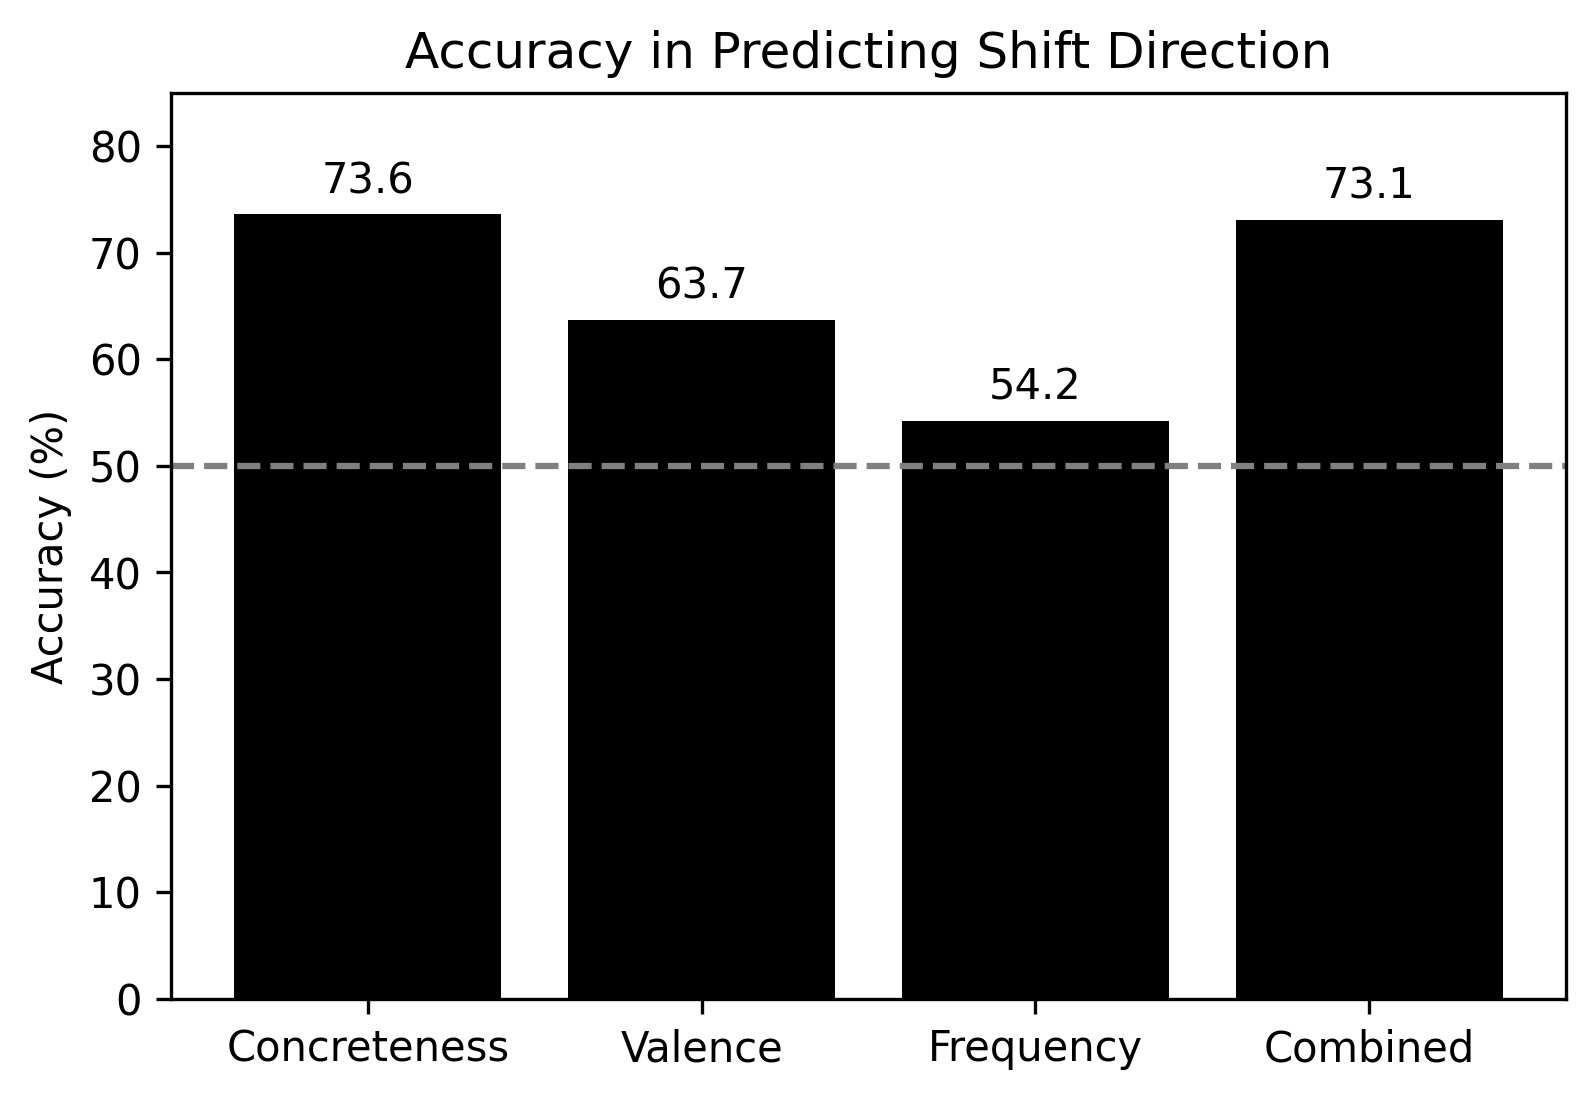

In [ ]:
#@title accuracy plot with all pairs (no realization filter)

heights = np.asarray([conc_accuracy, val_rate_accuracy, freq_accuracy, log_accuracy]).T
heights = [round(i*100, 1) for i in heights[0]]

x = np.arange(len(heights))  # the label locations

fig, ax = plt.subplots()
rects = ax.bar(x, heights, color='black')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy in Predicting Shift Direction')
ax.set_xticks(x, labels=['Concreteness', 'Valence', 'Frequency', 'Combined'])
ax.bar_label(rects, padding=3)
ax.set_ylim(0, 85)

ax.axhline(50, linestyle='--', c='gray')

plt.show()

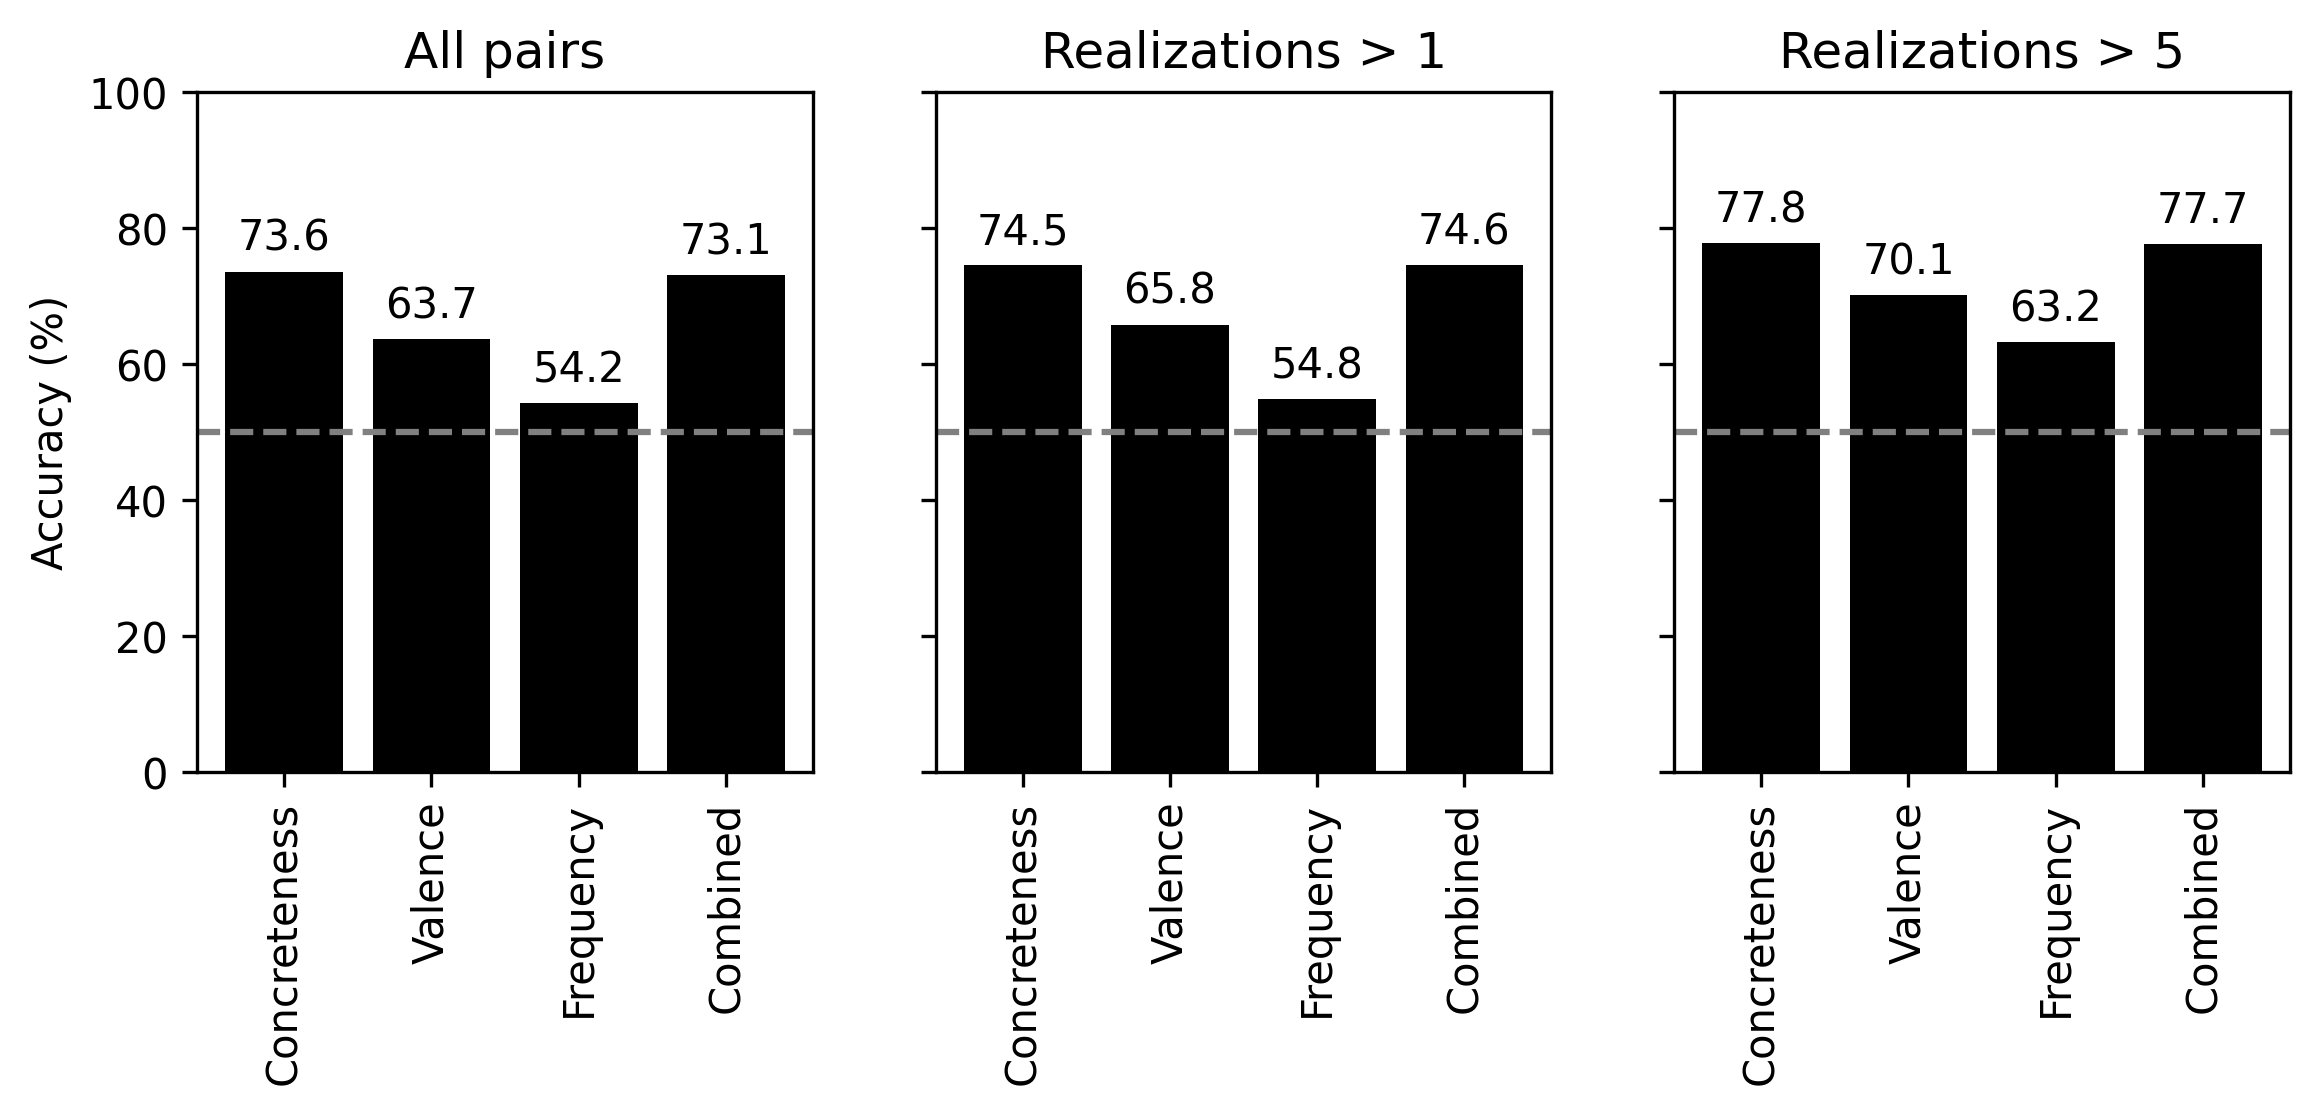

In [ ]:
#@title accuracy plot with realization filter

labels  = ['Concreteness', 'Valence', 'Frequency', 'Combined']

accuracies = np.asarray([conc_accuracy, val_rate_accuracy, freq_accuracy, log_accuracy]).T
accuracies = [[round(j*100, 1) for j in list] for list in accuracies]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

## general ax stuff
axs[0].set_ylim(0, 100)
axs[0].set_ylabel('Accuracy (%)')
# fig.suptitle('Accuracy for different realization filters')

## no filter on realizations

rects = axs[0].bar(x, accuracies[0], color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_xticks(x, labels=labels, rotation=90)
axs[0].bar_label(rects, padding=3)
axs[0].set_title("All pairs")
axs[0].axhline(50, linestyle='--', c='gray')

##  realizations > 1

rects = axs[1].bar(x, accuracies[1], color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xticks(x, labels=labels, rotation=90)
axs[1].bar_label(rects, padding=3)
axs[1].set_title("Realizations > 1")
axs[1].axhline(50, linestyle='--', c='gray')

##  realizations > 5

rects = axs[2].bar(x, accuracies[2], color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[2].set_xticks(x, labels=labels, rotation=90)
axs[2].bar_label(rects, padding=3)
axs[2].set_title("Realizations > 5")
axs[2].axhline(50, linestyle='--', c='gray')

plt.show()

## languages plot

In [ ]:
# import and clean the dataset

# get the dataset all figured out 
datSemShift = pd.read_csv('../data/datasets/datsemshift.csv')

# filter semantic shifts
datSemShift = datSemShift[(datSemShift['gendirection'] == '→')]
datSemShift = datSemShift[(datSemShift['type'] == ' Semantic evolution') | (datSemShift['type'] == ' Polysemy')]
datSemShift = datSemShift[(datSemShift['language1'] == datSemShift['language2'])]
datSemShift = datSemShift[(datSemShift['lexeme1'] == datSemShift['lexeme2'])]
datSemShift = datSemShift[~datSemShift['meaning1'].str.contains('<')]
datSemShift = datSemShift[~datSemShift['meaning2'].str.contains('<')]
datSemShift = datSemShift[(datSemShift['status']!='Suspended') & (datSemShift['status']!='Rejected')]
datSemShift = datSemShift[['meaning1', 'meaning2', 'language1']]
datSemShift = datSemShift.reset_index(drop=True)

dumb_british_spellings = {"vapour":"vapor", "honour":"honor", "organisation":"organization", "harbour":"harbor", "odour":"odor", "centre":"center", "analyse":"analyze", "theatre":"theater", "colour":"color", "rumour":"rumor", "behaviour":"behavior", "armour":"armor", "grey":"gray", 
"mould":"mold", "neighbour":"neighbor", "axe":"ax", "moustache":"mustache", "plough":"plow", "mandarine":"mandarin"}
words_to_replace = {"adj":"", "gipsy":"", "albumen":"", "campanula":"", "boletus edulis":"penny bun fungus", "ursus":"", "swearword":"swear word", 'adj.':"", "coleus":"", 'n.':"", 'ОК':"ok", "typha":"cattail", "pacifica":"peaceful", "mustella":"", "smail":"", "one’s":"", "spurflower":"perennial plant", "sabre":"","equus":"", "etc.":"", "ciconia":"",  "aër":"", "panthera":"panther", "еrinaceus":"", "e.g.":"", "centaurea":"thistle", "moschiferus":"", "apterus":"", "pyrrhocoris":"", "smn.":"", "pritchardia":"", "100":"one hundred", "sabrefish":"sabre carp", "putorius":"", "adv.":"", "petromyzontidae":"", "botaurus":"", "standart":"standard", "leccinum":"", "sg.":"", "gemini":"Gemini", "tabanidae":"", "anagallis":"", "decorticate":"stiff", "albugo":"", "frangula":"", "sciurus":"", "scrofa":"", "relig.":"", "headstream":"head stream", "solanum":"", "anguilla":"", "anat.":"", "nectarinia":"", "ipomoea":"", "repaire":"repair", "vaccinium":"", "smth":"", "smth.":"", "bubo":"", "deflorate":"remove flowers", "tr.":"", "traveller":"traveler", "bubalis":"", "marmorata":"", "furuncul":"", "caballus":"", "microchiroptera":"", "urtica":"", "plumbum":"", "biol.":"", "intr.":"", "bubalus":"", "columba":"", "cucurbita":"", "goldcrest":"small bird", "melongena":"", "picea":"", "arvensis":"", "moschus":"", "psidium":"", "radiointerference":"radio interference", "owre":"", "ricinus":"", "capricorn":"goat zodiac sign", "mustela":"", "pandion":"", "adj.of":"", "nomadize":"become nomadic", "smb.":"", "kneepit":"knee pit", "num.":"", "pl.":"", "extortioner":"extortion doer", "enculturate":"assimilate", "asquint":"squint", "uliginosum":"", "heteroptera":"", "ок":"ok", "abies":"fir", "stratiotes":"", "fiddlestick":"violin bow", "scabrum":"", "grus":"bird", "acarina":"", "guajava":"", "bitterling":"freshwater fish", "lycopersicum":"", "lutra":"otter", "plectranthus":"", "macereed":"mace reed", "24":"twenty four", "acris":"", "rotundifolius":"common weed", "gutturalis":"", "oxyeleotris":"", "geometrid":"", "citrullus":"", "lepus":"", "motacilla":"", "crake":"bird", "haliaёtus":"", "glasswort":"herb", "quinsy":"throat abscess", "shoulderblade":"shoulder blade", "spearthrower":"spear thrower", "ridgepole":"ridge pole", "pimpleface":"pimple face", "tumpline":"backpack", "cushma":"clothing", "curassow":"tropical bird", "banisterium":"plant", "paca":"rodent", "netbag":"net bag", "muntjacs":"barking deer"}
#Replaces obscure words with recognizable words, replaces parts of speech with nothing, same with science words


def clean(s): # Here is the main method where we clean senses
  s = str(s)
  for i in ",:":
    s = s.replace(i, " or")
  s = s.replace("/", " or ")
  for i in "()\t\n<>?’":
    s = s.replace(i, "")
  for i in "-":
    s = s.replace(i, " ")
  should_be_upper = {}
  for w in s.split(" "):
    if w != "" and w[0].isupper():
      should_be_upper = {w.lower():w.capitalize()} # Keeps track of which words should be capitalized
  s = s.lower() # Converts to lowercase
  for i in dumb_british_spellings: # Replaces British spelling with American ones
    s = s.replace(i, dumb_british_spellings[i])
  for i in words_to_replace: # Replaces all other obscure words 
    s = s.replace(i, words_to_replace[i])
  for i in should_be_upper: # Uppercases words which should be uppercase
    s = s.replace(i, should_be_upper[i])
  if len(s) > 2 and s[:3] == " or": # If the beginning word is or, that means our string was of the form "[removed word]," and we should delete the or
    s = s[3:]
  if "vs." in s: # For cases like "land (vs. sea)"" we want to convert this to "land"
    ind = s.find("vs.")
    s = s[:ind]
  s = s.replace(".","")
  return s

languages_df = datSemShift.copy()
languages_df['meaning1'] = languages_df["meaning1"].apply(clean)
languages_df['meaning2'] = languages_df["meaning2"].apply(clean)

In [ ]:
# get the useful databases
language_count_df = languages_df.groupby('language1').count().sort_values(by='meaning1', ascending=False)
common_languages = list(language_count_df[language_count_df['meaning1'] > 100].index)

# merge in freq/conc/val data to this database
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [languages_df, conc_sense_df]).drop('Word', axis=1)
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [languages_df, conc_sense_df]).drop('Word', axis=1)
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [languages_df, freq_sense_df]).drop('Word', axis=1)
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [languages_df, freq_sense_df]).drop('Word', axis=1)
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [languages_df, val_sense_df]).drop('Word', axis=1)
languages_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [languages_df, val_sense_df]).drop('Word', axis=1)

In [ ]:
# calculate accuracy of each variable for each shift

languages_df['freq_x'] = np.log(languages_df['freq_x'])
languages_df['freq_y'] = np.log(languages_df['freq_y'])

languages_df['conc_diff'] = languages_df['conc_y'] - languages_df['conc_x']
languages_df['freq_diff'] = languages_df['conc_y'] - languages_df['freq_x']
languages_df['val_diff'] = languages_df['val_y'] - languages_df['val_x']
languages_df['val_rate_diff'] = languages_df['val_rate_y'] - languages_df['val_rate_x']

languages_df['conc_ratio'] = languages_df['conc_x'] / languages_df['conc_y']
languages_df['freq_ratio'] = languages_df['freq_x'] / languages_df['freq_y']
languages_df['val_ratio'] = languages_df['val_x'] / languages_df['val_y']
languages_df['val_rate_ratio'] = languages_df['val_rate_x'] / languages_df['val_rate_y']

languages_df['conc_acc'] = np.where(languages_df['conc_ratio'] > 1, 1, 0)
languages_df['freq_acc'] = np.where(languages_df['freq_ratio'] > 1, 1, 0)
languages_df['val_acc'] = np.where(languages_df['val_ratio'] > 1, 1, 0)
languages_df['val_rate_acc'] = np.where(languages_df['val_rate_ratio'] < 1, 1, 0)

languages_df['realizations'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# get accuracy of each variable per language

conc_languages_df = languages_df[~np.isnan(languages_df['conc_ratio'])].groupby('language1').sum()[['conc_acc', 'realizations']] # get accurate and total realizations
conc_languages_df['accuracy'] = conc_languages_df['conc_acc'] / conc_languages_df['realizations'] # calculate accuracy by language

freq_languages_df = languages_df[~np.isnan(languages_df['freq_ratio'])].groupby('language1').sum()[['freq_acc', 'realizations']] # get accurate and total realizations
freq_languages_df['accuracy'] = freq_languages_df['freq_acc'] / freq_languages_df['realizations'] # calculate accuracy by language

val_rate_languages_df = languages_df[~np.isnan(languages_df['val_rate_ratio'])].groupby('language1').sum()[['val_rate_acc', 'realizations']] # get accurate and total realizations
val_rate_languages_df['accuracy'] = val_rate_languages_df['val_rate_acc'] / val_rate_languages_df['realizations'] # calculate accuracy by language

In [ ]:
# create the database and sort by language

common_languages.sort()
accuracy_df = pd.DataFrame(common_languages).rename(columns={0:'language'})
accuracy_df = reduce(lambda  left,right: pd.merge(left,right,left_on='language',right_on='language1', how='left'), [accuracy_df, conc_languages_df]).rename(columns={'accuracy':'conc_accuracy'})
accuracy_df = reduce(lambda  left,right: pd.merge(left,right,left_on='language',right_on='language1', how='left'), [accuracy_df, freq_languages_df]).rename(columns={'accuracy':'freq_accuracy'})
accuracy_df = reduce(lambda  left,right: pd.merge(left,right,left_on='language',right_on='language1', how='left'), [accuracy_df, val_rate_languages_df]).rename(columns={'accuracy':'val_rate_accuracy'})
accuracy_df = accuracy_df[['language', 'conc_accuracy', 'val_rate_accuracy', 'freq_accuracy']]
accuracy_df = accuracy_df.sort_values(by='language')

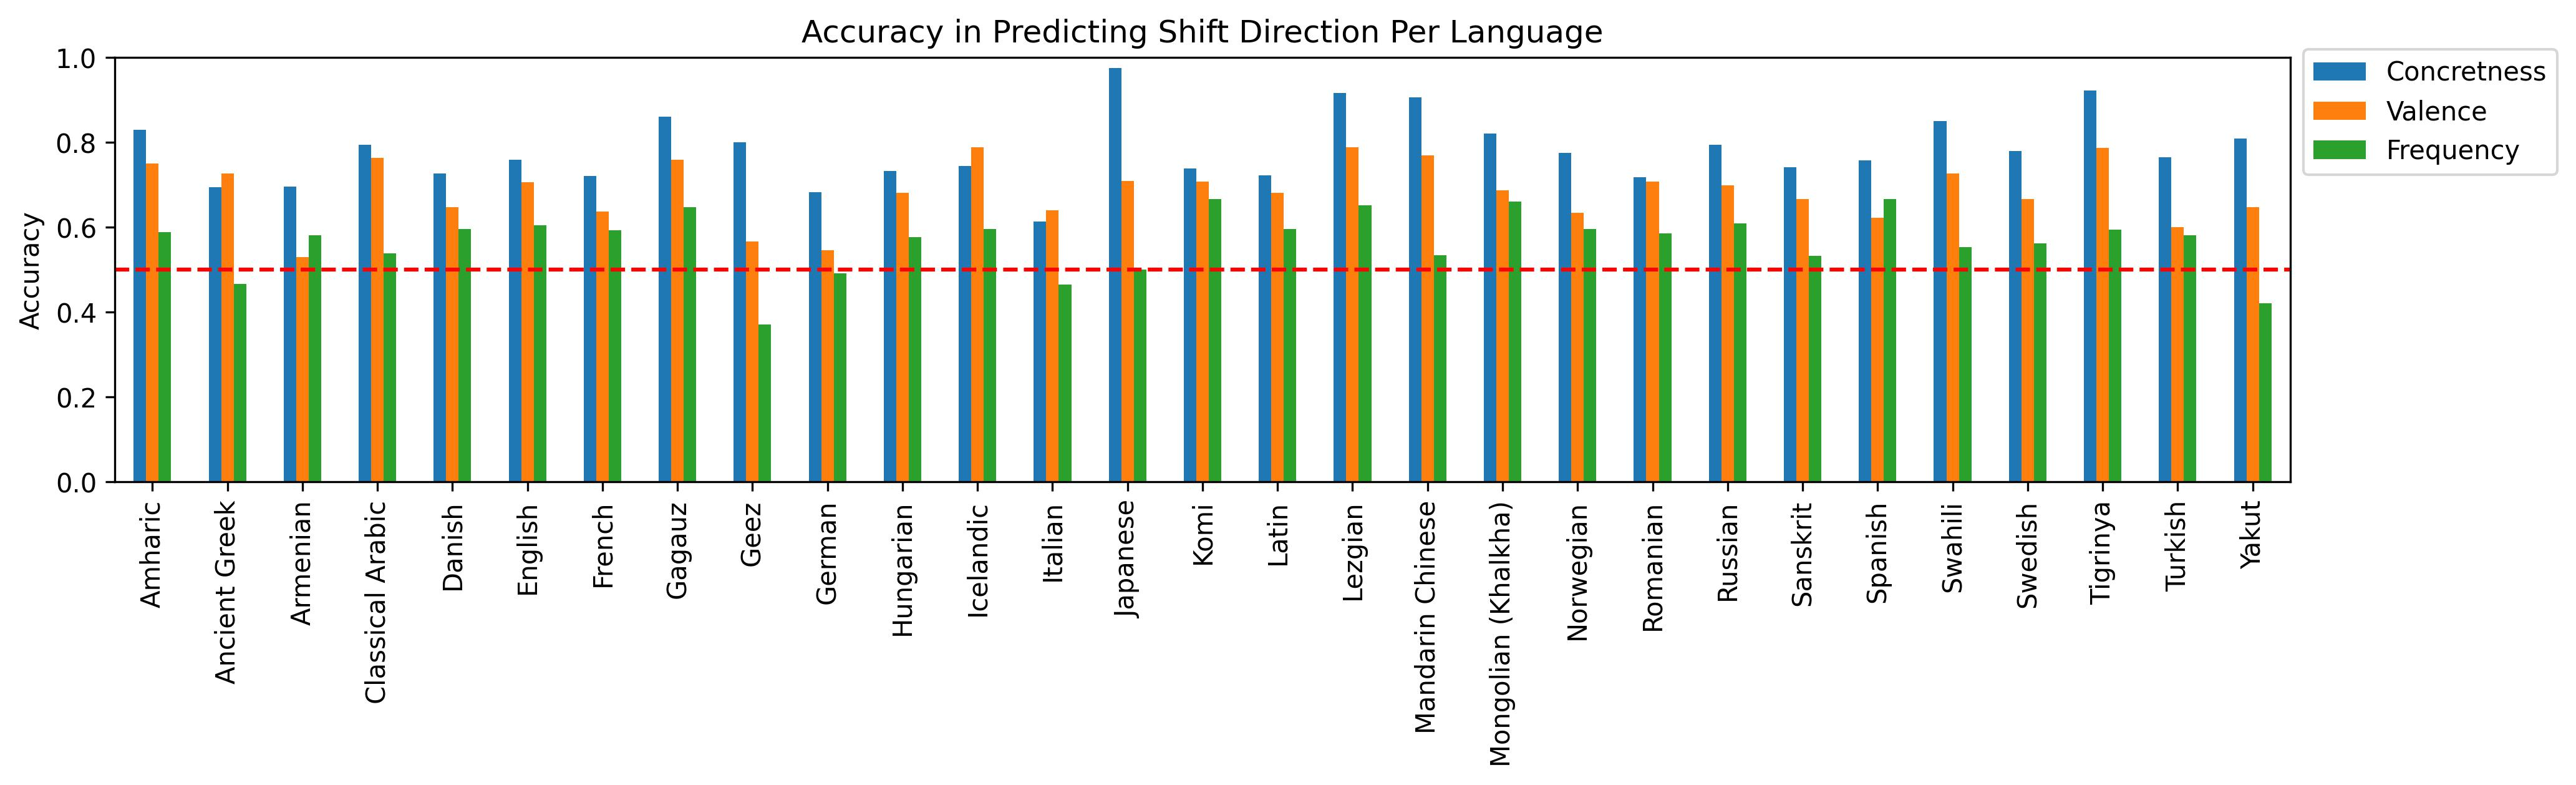

In [ ]:
# create the figure 

common_languages.sort()
labels = common_languages

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
ax = accuracy_df.plot(kind='bar', figsize=(15, 3))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy in Predicting Shift Direction Per Language')
ax.set_xticks(x, labels=labels, rotation=90)
ax.legend(labels=['Concretness', 'Valence', 'Frequency'], bbox_to_anchor=(1, 1.05))
ax.set_ylim(0, 1)

ax.axhline(0.5, linestyle='--', c='red')

plt.show()